# Lab 1 Task 2

In [1]:
!pip install thop
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary

In [3]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [4]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


[0.49139914 0.482159   0.4465296 ] [0.24703261 0.2434855  0.26158747]
[0.49139914 0.482159   0.4465296 ] [0.24703261 0.2434855  0.26158747]


In [ ]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Transform to tensor
    transforms.Normalize(mean=train_mean, std=train_std), # Normalization
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [6]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

image shape:  torch.Size([3, 224, 224])
train length:  45000
val length:  5000
test length:  10000


In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # conv1: 7*7, stride = 2 + BN + ReLU + maxpool
        self.conv1  = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.in_channels = 64

        #conv2 ~ 5
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        #Avearge pooling + connect
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)



    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        # Update output channel
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
          layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        #Resdiual
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        #Avgpool
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

#Test
if __name__ == "__main__":
    model = ResNet18(num_classes=10)
    print(model)
    x = torch.rand(1,3,224,224)
    y = model(x)
    print(y.shape)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [8]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

model = ResNet18(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print model summary
summary(model, (3, 224, 224))

# Calculate FLOPs and Params
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR # <--- 新增：匯入 Scheduler
# 假設你的 model, trainloader, valloader, writer 已經定義好了

# Setting parameter
EPOCH = 30
pre_epoch = 0
lr = 1e-4

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH, eta_min=0)

best_model_path = 'best_resnet18.pth'

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)

    #Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          val_loss += loss.item()*inputs.size(0)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      val_loss = val_loss / len(valloader.dataset)
      val_acc = 100. * correct / total
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)

    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

    current_lr = optimizer.param_groups[0]['lr'] # 取得目前的學習率
    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCH}] | Current LR: {current_lr:.6f} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print(f"\n訓練完成！最佳驗證準確率為: {best_val_acc:.2f}%，模型已儲存至 {best_model_path}")

Epoch [1/30] | Current LR: 0.000100 | Train Loss: 1.7023 | Train Acc: 37.48% | Val Loss: 1.6295 | Val Acc: 39.76%
Epoch [2/30] | Current LR: 0.000100 | Train Loss: 1.4046 | Train Acc: 49.58% | Val Loss: 1.4331 | Val Acc: 48.62%
Epoch [3/30] | Current LR: 0.000099 | Train Loss: 1.2279 | Train Acc: 56.25% | Val Loss: 1.2537 | Val Acc: 55.42%
Epoch [4/30] | Current LR: 0.000098 | Train Loss: 1.1126 | Train Acc: 60.69% | Val Loss: 1.2622 | Val Acc: 55.94%
Epoch [5/30] | Current LR: 0.000096 | Train Loss: 1.0179 | Train Acc: 64.25% | Val Loss: 1.0619 | Val Acc: 62.86%
Epoch [6/30] | Current LR: 0.000093 | Train Loss: 0.9623 | Train Acc: 66.29% | Val Loss: 0.9964 | Val Acc: 65.44%
Epoch [7/30] | Current LR: 0.000090 | Train Loss: 0.9110 | Train Acc: 67.94% | Val Loss: 1.0165 | Val Acc: 64.16%
Epoch [8/30] | Current LR: 0.000087 | Train Loss: 0.8669 | Train Acc: 69.58% | Val Loss: 0.9792 | Val Acc: 65.88%
Epoch [9/30] | Current LR: 0.000083 | Train Loss: 0.8319 | Train Acc: 70.80% | Val Loss:

In [12]:
# Load the best model and evaluate on the test set
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")

Best Model Test Accuracy: 90.03%


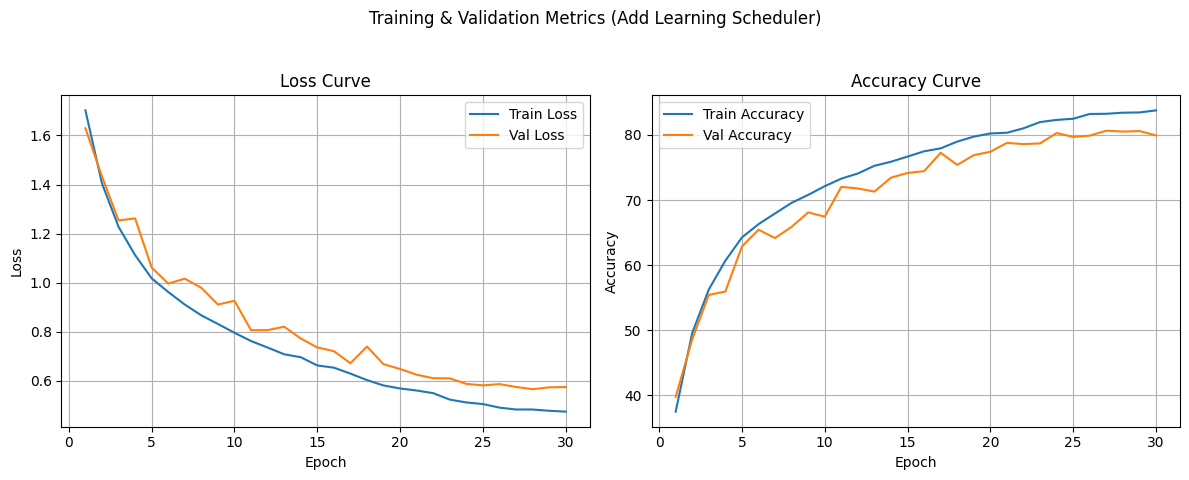

In [11]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
epochs = range(1, EPOCH+1)

plt.figure(figsize=(12, 5))
plt.suptitle('Training & Validation Metrics (Add Learning Scheduler)')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()